# Introduction

This Jupyter notebook is an implementation, for Jordan Chark's doctoral dissertation, of the model described in:

   Ahern, Christopher and Robin Clark. Conflict, Cheap Talk, and Jespersen's Cycle. 2017.

The model itself remains unchanged, though its interpretation differs from the original conception somewhat, and it is fitted to an altogether different dataset.



In [ ]:
!python --version

Python 3.10.12


In [ ]:
import IPython
import sys
import numpy as np
import scipy
print('Python version: ', sys.version)
print('Platform: ', sys.platform)
print()
print('IPython version: ', IPython.__version__)
print('NumPy version: ', np.__version__)
print('SciPy version: ', scipy.__version__)


Python version:  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Platform:  linux

IPython version:  7.34.0
NumPy version:  1.25.2
SciPy version:  1.11.4


In this section we focus on the prior probability distribution over states and visualize the utility functions used in the game.

# Evolutionarily stable strategies of the signaling game

We begin by mounting GDrive in order to import the corpus data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dynamics

The data was export using the following code, in accordance with the procedure of Ahern and Clark 2017. The dataset imported ranges temporally from 1780-1910, i.e. 130 years. This is dictated by the constraints of the corpus; though we have data beyond 1910, it is overwhelmingly from two speakers, both male. Thus in order to model the most representative sample possible, I stick to this period.

In [ ]:
%%R
cycle.data.f = data.frame(year=rep(0, 131), has.tokens=rep(0,131),
                          ones=rep(0, 131), zeros=rep(0, 131))
for (i in c(0:131)) {
  cycle.data.f$year[i] = i + 1780 - 1
  cycle.data.f$has.tokens[i] = nrow(female_presind %>%
                                      filter(year == i + 1780 - 1)) > 0
  cycle.data.f$ones[i] = nrow(female_presind %>%
                                filter(year == i + 1780 - 1, response == 1))
  cycle.data.f$zeros[i] = nrow(female_presind %>%
                                 filter(year == i + 1780 - 1, response == 0))
}

## Defining the evolutionary game dynamics

I refer to the appendix of Ahern and Clark 2017 for the mathematical details. Here we proceed with model fitting. First by defining the dynamics.

In [ ]:
def discrete_time_replicator_dynamics(n_steps, X, Y, A, B, P):
    """Simulate the discrete-time replicator dynamics.

    Parameters
    ----------
    n_steps : int, the number of discrete time steps to simulate
    X : stochastic sender matrix
    Y : stochastic receiver matrix
    A : sender utility matrix
    B : receiver utility matrix
    P : prior probability over states matrix

    Returns
    ----------
    X_t : array-like, the state of the sender population at each year
    Y_t : array-like, the state of the receiver population at each year
    """
    # Get the number of states
    X_nrow = X.shape[0]
    # Get the number of messages
    X_ncol = X.shape[1]
    # Get the number of actions
    Y_nrow = Y.shape[0]
    Y_ncol = Y.shape[1]
    # Create empty arrays to hold flattened matrices for the population over time
    X_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    Y_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    # Set the initial state
    X_t[0,:] = X.ravel()
    Y_t[0,:] = Y.ravel()
    # Iterate forward over (n-1) steps
    for i in range(1,n_steps):
        # Get the previous state
        X_prev = X_t[i-1,:].reshape(X_nrow, X_ncol)
        Y_prev = Y_t[i-1,:].reshape(Y_nrow, Y_ncol)
        # Calculate the scaling factors
        E_X = A * Y_prev.T
        X_bar = (((A * Y_prev.T) * X_prev.T).diagonal()).T
        X_hat = E_X / X_bar
        # Calculate probability of states given messages
        C = np.divide(np.multiply(P.T, X_prev), (P * X_prev)[0])
        E_Y = (B.T * C).T
        Y_bar = ((E_Y*Y_prev.T).diagonal()).T
        Y_hat = np.divide(E_Y, Y_bar)
        # Calculate current states
        X_t[i,:] = np.multiply(X_prev, X_hat).ravel()
        Y_t[i,:] = np.multiply(Y_prev, Y_hat).ravel()
    return X_t, Y_t

The procedure proceeds by defining the individual model components.

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy.optimize import fmin
from scipy.special import beta as beta_func
from scipy.special import binom
from scipy.special import comb
from scipy.stats import chi2
from functools import partial

import matplotlib.pyplot as plt
plt.style.use('ggplot')
hfont = {'fontname':'Times New Roman'}


def beta_binomial(alpha, beta, n=100):
    return np.matrix([comb(n-1,k) * beta_func(k+alpha, n-1-k+beta) / beta_func(alpha,beta)
                        for k in range(n)])

def U_S(state, action, b):
    return 1 - (action - state - (1-state)*b)**2
def U_R(state, action):
    return 1 - (action - state)**2

def t(i, n):
    return i/float(n)
def a(i, n):
    return i/float(n)

def sender_matrix(b, number=100):
    return np.matrix([[U_S(t(i, number-1), a(j,number-1), b)
                       for j in range(number)] for i in range(number)])
def receiver_matrix(number=100):
    return np.matrix([[U_R(t(i, number-1), a(j,number-1))
                       for j in range(number)] for i in range(number)])


def construct_initial_state(a_s, b_p, b=0):
    """Construct the initial state of the model.

    Parameters
    ----------
    a_s, b_p, b : parameters defined in document

    Returns
    ----------
    X0 : array-like, the initial state of the speaker population
    Y0 : array-like, the initial state of the hearer population
    prior : prior probability over states
    """
    # Define prior probability
    a_p = 1
    prior = beta_binomial(a_p, b_p)
    P = np.repeat(prior, 2, axis=0)
    # Define payoff matrices
    A = sender_matrix(b)
    B = receiver_matrix(    )
    # Define speaker population
    X0_m2 = beta_binomial(a_s, 1)
    X0_m1 = 1 - X0_m2
    X0 = np.vstack((X0_m1, X0_m2)).T
    # Calculate probability of state given m2
    p_ti_m2 = np.multiply(X0[:,1], prior.T)
    p_m2 = prior * X0[:,1]
    p_t_m2 = p_ti_m2 / p_m2
    # Calculate probability of state given m1
    p_ti_m1 = np.multiply(X0[:,0], prior.T)
    p_m1 = prior * X0[:,0]
    p_t_m1 = p_ti_m1 / p_m1
    # Calculate expected utility for receiver of action given m1
    E_ai_m1 = p_t_m1.T * B
    E_a_m1 = E_ai_m1 / E_ai_m1.sum()
    # Calculate expected utility for receiver of action given m2
    E_ai_m2 = p_t_m2.T * B
    E_a_m2 = E_ai_m2 / E_ai_m2.sum()
    # Define hearer population
    Y0 = np.vstack([E_a_m1, E_a_m2])

    return X0, Y0, A, B, prior

The next step is to simulate the dynamics, this time setting the n_years parameter to 131.

In [ ]:
def simulate_dynamics(params, n_years=131, time_scale=1, number=130):
    """Simulate the discrete-time behavioral replicator dynamics for the game.

    Parameters
    ----------
    n_years : int, the number of discrete time steps to simulate
    time_scale : int (optional), the number of discrete time steps per year
    number : int, (optional), the number of discretized states and actions
    params : array-like, parameters that determine starting state of population

    Returns
    ----------
    X_sol : array-like, the state of the speaker population at each year
    Y_sol : array-like, the state of the hearer population at each year
    prior : prior probability over states
    """
    # Unpack the parameters
    a_s, b_p, b = params
    # Construct the initial state
    X0, Y0, A, B, prior = construct_initial_state(a_s, b_p, b)
    # Create prior probability matrix
    P = np.repeat(prior, 2, axis=0)
    # Iterate using dynamics to get values for the number of years
    X_sol, Y_sol = discrete_time_replicator_dynamics(
                            n_years*time_scale, X0, Y0, A, B, P)
    X_sol = X_sol[0::time_scale,:]
    Y_sol = Y_sol[0::time_scale,:]
    return X_sol, Y_sol, prior

## Fitting the dynamic model to historical corpus data

The procedure continues: we read in the data and define a loss function, corresponding to the negative log-likelihood for the parameters in question.

In [ ]:
func_data = pd.read_csv('/content/drive/MyDrive/colab/new_april/pres-cycle-female.csv')

def loss_function(params, func=simulate_dynamics, time_scale=1, df=func_data):
    """Calculate the loss function.

    Parameters
    ----------
    params : array-like, parameters that determine starting state of population
    func : model begin fit to the data
    time_scale : int (optional), the number of discrete time steps per year
    number : int, (optional), the number of discretized states and actions
             default is one "generation" of the dynamics per year
    df : data to use, default is from func_data

    Returns
    ----------
    negLL : float, negative log likelihood to be minimized
    """
    # Simulate the dynamics
    X_sol, Y_sol, prior = func(params, n_years=131, time_scale=time_scale)
    # Get p(m_2) over time
    m2_sol = np.asarray([prior.dot(line)[0,0] for line in X_sol[:,1::2]])
    # Append solution trajectory to data frame
    # Use approximate value when trajectory reaches boundary
    df['p'] = np.minimum(m2_sol.ravel(), np.repeat(.9999999, len(m2_sol)))
    # Add binomial coefficient
    df['binom'] = binom(df.ones + df.zeros, df.ones)
    # Calculate log-likelihood for
    df['LL'] = np.log(df.binom) + (df.ones * np.log(df.p)) + (df.zeros * np.log(1 - df.p))
    # Only use years that have tokens
    df = df[df['has.tokens'] == 1]
    # Calculate log likelihood given m2_sol
    LL = np.sum(df['LL'])
    negLL = -1*LL
    # Minimizing negative log-likelihood is equivalent to maximizing log-likelihood
    return negLL

Now we are finally in a position to calculate the parameters which maximize the models log-likelihood.

In [ ]:
rranges = (slice(1, 20, 1), slice(1, 20, 1), slice(0, 1, 0.05))
model_results = brute(loss_function, rranges, finish=fmin)

In [ ]:
print(model_results)

[105.02926861   1.81162511   0.75426008]


Now the model can be simulated on the basis of these paramater values.

In [ ]:
X_sol, Y_sol, prior = simulate_dynamics(model_results)

In [ ]:
if isinstance(X_sol, (np.ndarray, pd.DataFrame)):
    print("Shape of X_sol:", X_sol.shape)
if isinstance(Y_sol, (np.ndarray, pd.DataFrame)):
    print("Shape of Y_sol:", Y_sol.shape)
if isinstance(prior, (np.ndarray, pd.DataFrame)):
    print("Shape of prior:", prior.shape)


Shape of X_sol: (131, 200)
Shape of Y_sol: (131, 200)
Shape of prior: (1, 100)


To visualize, we can look at: proportion of new form over time, conditional probability and KL-divergence, i.e. informativity.

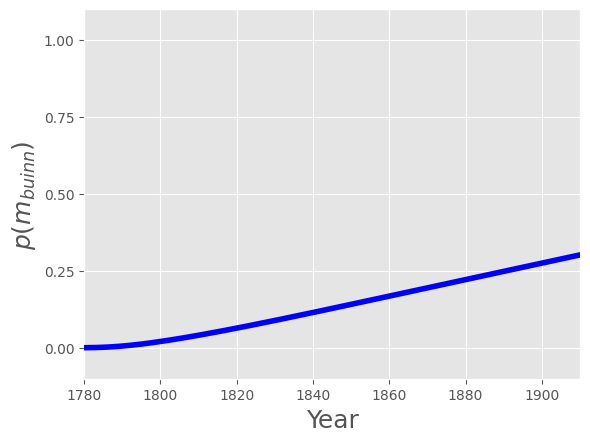

In [ ]:
states = np.linspace(0,1, num=100)
timesteps=131

m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
years = [1780 + item for item in range(131)]

plt.plot(years, m2_sol, 'b', linewidth=4, zorder=3)
plt.ylim(-.1,1.1)
plt.xlim(1780, 1910)
plt.xlabel('Year', fontsize=18, **hfont)
plt.yticks(np.linspace(0, 1, num=5))
plt.ylabel(r'$p(m_{buinn})$', fontsize=18, **hfont)
plt.show()

We can also simulate for future years, say until 2030.

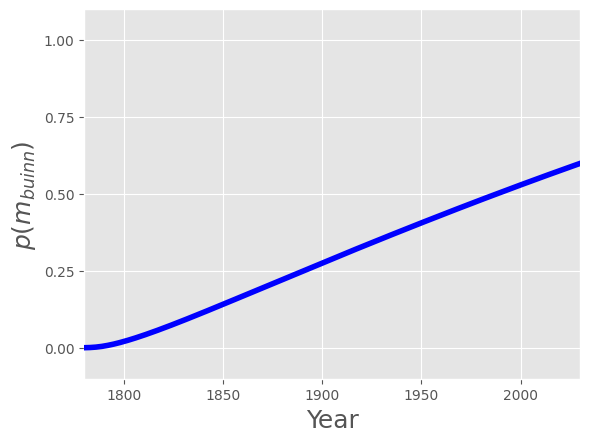

In [ ]:
X_sol, Y_sol, prior = simulate_dynamics(model_results, n_years=251)

m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
years = [1780 + item for item in range(251)]

plt.plot(years, m2_sol, 'b', linewidth=4, zorder=3)
plt.ylim(-.1,1.1)
plt.xlim(1780, 2030)
plt.xlabel('Year', fontsize=18, **hfont)
plt.yticks(np.linspace(0, 1, num=5))
plt.ylabel(r'$p(m_{buinn})$', fontsize=18, **hfont)
plt.show()

Also informative is the KL-divergence over time.

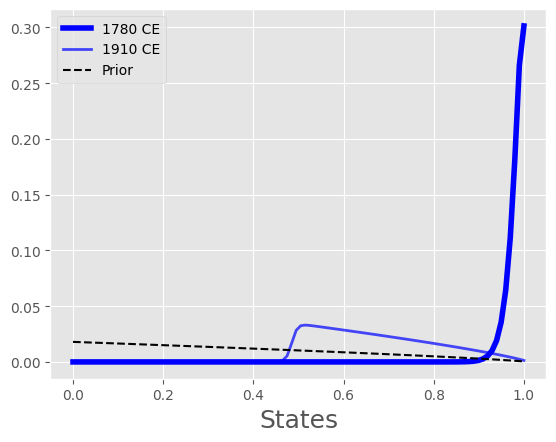

In [ ]:
# Define the years for the plot
start_year = 1780
end_year = 1910

# Calculate the index step for each year in X_sol
index_step = len(X_sol) // (end_year - start_year + 1)

# Get the indices for start and end year
index_1780 = (start_year - start_year) * index_step
index_1910 = (end_year - start_year) * index_step

# Plot for 1800
p_ti_m2_1780 = np.multiply(X_sol[index_1780, 1::2], prior)
p_m2_1780 = X_sol[index_1780, 1::2] * prior.T
p_t_m2_1780 = p_ti_m2_1780 / p_m2_1780
plt.plot(states, p_t_m2_1780.tolist()[0], 'b', linewidth=4, label=f"{start_year} CE")

# Plot for 1900
p_ti_m2_1910 = np.multiply(X_sol[index_1910, 1::2], prior)
p_m2_1910 = X_sol[index_1910, 1::2] * prior.T
p_t_m2_1910 = p_ti_m2_1910 / p_m2_1910
plt.plot(states, p_t_m2_1910.tolist()[0], 'b', linewidth=2, label=f"{end_year} CE", alpha=0.7)

# Plot the prior
plt.plot(states, prior.tolist()[0], 'k--', label='Prior')

plt.xlabel('States', fontsize=18, **hfont)
plt.legend()
plt.show()

In [ ]:
def calculate_KL(p_t_m, prior):
    KL = np.sum(np.multiply(np.log(np.divide(p_t_m, prior)), p_t_m))
    return KL

In [ ]:
def calculate_KL(p_t_m, prior):
    epsilon = 1e-10  # Small constant to avoid division by zero and log(0)
    p_t_m_adj = np.clip(p_t_m, epsilon, 1)
    prior_adj = np.clip(prior, epsilon, 1)
    KL = np.sum(np.multiply(np.log(np.divide(p_t_m_adj, prior_adj)), p_t_m_adj))
    return KL

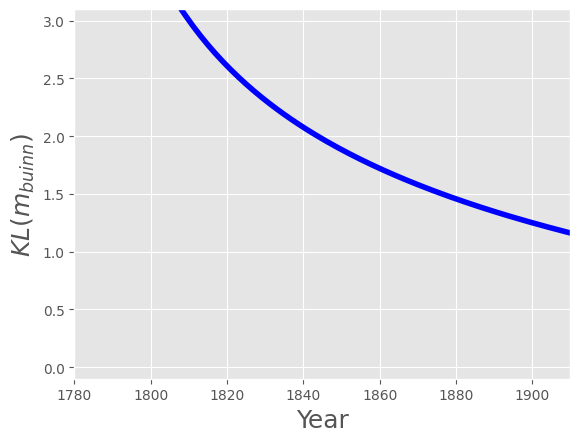

In [ ]:
KL_t = []
for i in range(131):
    p_ti_m2 = np.multiply(X_sol[i,1::2], prior)
    p_m2 =  X_sol[i,1::2] * prior.T
    p_t_m2 = p_ti_m2 / p_m2
    KL_t.append(calculate_KL(p_t_m2, prior))


years = [1780 + item for item in range(131)]

plt.plot(years, KL_t, 'b', linewidth=4)
plt.ylim(-.1, 3.1)
plt.xlim(1780,1910)
plt.xlabel('Year', fontsize=18, **hfont)
plt.yticks(np.linspace(0, 3, num=7))
plt.ylabel(r'$KL(m_{buinn})$', fontsize=18, **hfont)
plt.show()

## Comparison with simplified model

Now we can evaluate if a model with a bias parameter is justified by the data. We simulate a simplified model where bias us set to 0.

In [ ]:
def simulate_simplified_dynamics(params, n_years=131, time_scale=1, number=130):
    # Unpack the parameters
    a_s, b_p = params
    # Construct the initial state
    X0, Y0, A, B, prior = construct_initial_state(a_s, b_p)
    # Create prior probability matrix
    P = np.repeat(prior, 2, axis=0)
    # Iterate using dynamics to get values for the number of years
    X_sol, Y_sol = discrete_time_replicator_dynamics(n_years*time_scale, X0, Y0, A, B, P)
    X_sol = X_sol[0::time_scale,:]
    Y_sol = Y_sol[0::time_scale,:]
    return X_sol, Y_sol, prior

And find the best fitting parameters according to a simplified loss function.

In [ ]:
simplified_loss_function = partial(loss_function, func=simulate_simplified_dynamics)
rranges = (slice(1, 20, 1), slice(1, 20, 1))
simplified_results = brute(simplified_loss_function, rranges, finish=fmin)
print(simplified_results)

[1.23252705 1.9266252 ]


The plot below represents the prior probability over states for these parameters.

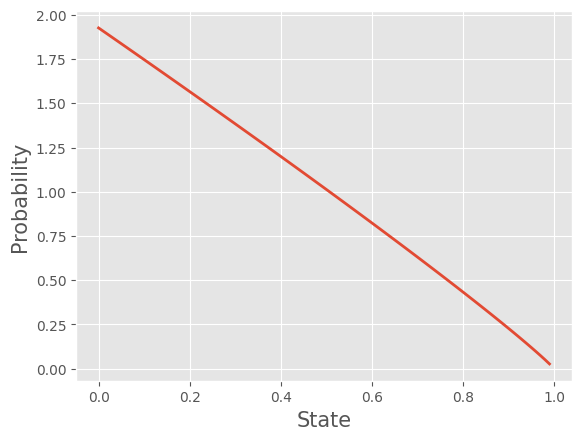

In [ ]:
from scipy.stats import beta
x = np.arange (0, 1, 0.01)
b_p = simplified_results[1]
plt.style.use('ggplot')
y = beta.pdf(x, 1, b_p)
plt.plot(x, y, linewidth=2)
plt.ylabel("Probability", fontsize=15, **hfont)
plt.xlabel("State", fontsize=15, **hfont)
plt.show()

We can also simulate the model with these parameters extending into the future. We observe that the model expects the change to stabilise.

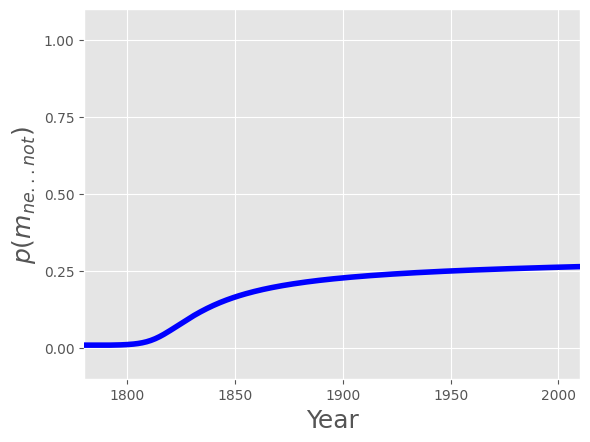

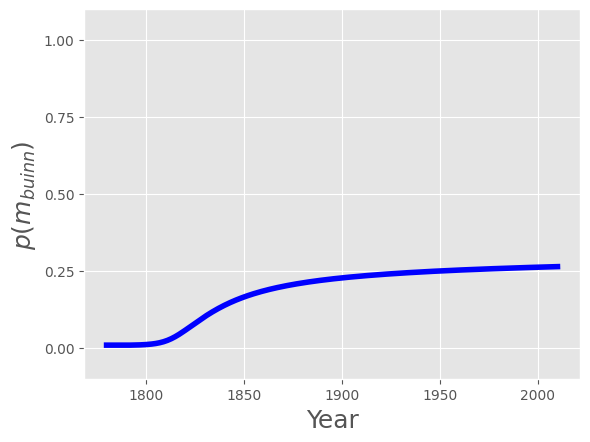

In [ ]:
X_sol, Y_sol, prior = simulate_simplified_dynamics(simplified_results, n_years=231)
m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]

years = [1780 + item for item in range(231)]

plt.plot(years[:231], m2_sol[:231], 'b', linewidth=4, zorder=3)
plt.ylim(-.1,1.1)
plt.xlim(1780, 2010)
plt.xlabel('Year', fontsize=18, **hfont)
plt.yticks(np.linspace(0, 1, num=5))
plt.ylabel(r'$p(m_{ne...not})$', fontsize=18, **hfont)
plt.show()

plt.plot(years, m2_sol, 'b', linewidth=4, zorder=3)
plt.ylim(-.1,1.1)
plt.xlabel('Year', fontsize=18, **hfont)
plt.yticks(np.linspace(0, 1, num=5))
plt.ylabel(r'$p(m_{buinn})$', fontsize=18, **hfont)
plt.show()

Model comparison via AIC. delta_AIC is the difference between the two models.

In [ ]:
full_LL = -1 * loss_function(model_results)
simple_LL = -1*loss_function(simplified_results, func=simulate_simplified_dynamics)

full_AIC = 2*3 - 2*full_LL
simple_AIC = 2*2 - 2*simple_LL
delta_AIC =  simple_AIC - full_AIC
print(delta_AIC)


12.568856898764864


The simplified model has a higher AIC given by the value above. Accordingly, the probability that the SIMPLIFIED model is better is then equated to its Akaike weight.

In [ ]:
1 / (1 + np.exp(.5*delta_AIC))

0.0018616504707044599

Given nested models, a Likelihood Ratio test is possible. Here the test statistic $D$ is $\chi^2$ distributed with one degree of freedom. Right tailed $\chi^2$ tells us the probability of observing a test statistic as extreme as D or more extreme, in the right tail of the distribution.


In [ ]:
from scipy.stats import chi2
D = 2*(full_LL - simple_LL)
chi2_result = chi2.sf(D,1)
print(chi2_result)

0.00013512949365383214


We cannot reject the null hypothesis; the bias parameter is justified.

# References

* Jäger, Gerhard, Lars P Metzger & Frank Riedel. 2011. Voronoi languages: Equilibria in cheap-talk games with high-dimensional types and few signals. Games and economic behavior 73(2). 517–537. http://dx.doi.org/10.1016/j.geb.2011.03.008.

* Crawford, Vincent P & Joel Sobel. 1982. Strategic information transmission. Econometrica 1431–1451. http://dx.doi.org/10.2307/1913390.

* Hofbauer, Josef & Simon M Huttegger. 2015. Selection-mutation dynamics of signaling games. Games 6(1). 2–31. http://dx.doi.org/10.3390/g6010002.